# Multi-Layer Perceptron 

- 多层感知机，即前馈神经网络。MLP，FNN
- 由输入层，隐层和输出层组成，隐层可以有多层。
- 降低泛化误差
    - 模型选择
      - 候选模型可以是有不同超参数的模型，比如MLP的隐层个数，隐层神经元个数，激活函数等都可以是超参数。
      - 通过dev或者validation set来选择模型
      - 当数据量有限时，通过K折交叉验证来选择模型，充分利用数据
    - 过拟合&欠拟合
      - 欠拟合表现在bias大
      - 过拟合表现在variance大
    - 解决方法
      - 权重衰减weight decay
        - 权重衰减可以通过优化器中的weight_decay超参数来指定。
      - 丢弃法dropout
        - 只在训练的时候运用
        - nn.Dropout(prob)
   - 数值稳定性以及模型初始化
     - 深度模型有关数值稳定性的典型问题是衰减和爆炸，当层数增大，应当考虑稳定性问题
     - 使用torch.nn.init.normal_()使模型net的权重参数采用正态分布的随机初始化方式。不过，PyTorch中nn.Module的模块参数都采取了较为合理的初始化策略（不同类型的layer具体采样的哪一种初始化方法的可参考源代码），因此一般不用我们考虑。
     - 一种常用的随机初始化方法叫Xavier随机初始化，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布：$U(-(\frac6{a+b})^{\frac12},\frac6{a+b})^{\frac12})$ a是券链接的输入个数，b是输出个数


## Activate Functions

- 多层感知机中至少有一个隐藏层，因此每个隐藏层的输出需要经过激活函数变换，常用的激活函数有sigmoid，relu，tanh及其变体

In [6]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')


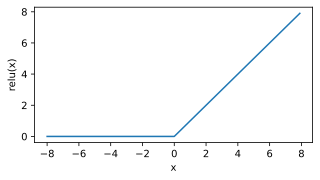

In [27]:
# the ReLU function
# plot relu

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
#y = x.sigmoid()
#y = x.tanh()

xyplot(x,y,'relu')

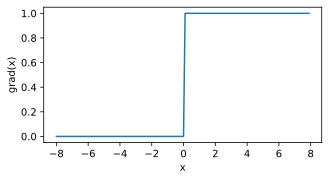

In [28]:
# plot x-grad with x

#x.grad.zero_()  # clear the gradient 
y.sum().backward()  # use .sum() to turn tesor to scala 
xyplot(x,x.grad,'grad')


## MLP from scratch

- 一些细节：
  - 有三个关于矩阵乘法的函数：
    - torch.mm：矩阵乘法 mat*mat
    - torch.matmul：张量乘法 tensor*tensor
    - torch.bmm：两个batch矩阵乘法 (batch,n,m)*(batch,m,p)
  - 因为手动实现没有optimizor，所以得传入train_ch3参数，设置lr为100
    - 由于原书的mxnet中的SoftmaxCrossEntropyLoss在反向传播的时候相对于沿batch维求和了，而PyTorch默认的是求平均，所以用PyTorch计算得到的loss比mxnet小很多（大概是maxnet计算得到的1/batch_size这个量级），所以反向传播得到的梯度也小很多，所以为了得到差不多的学习效果，我们把学习率调得成原书的约batch_size倍，原书的学习率为0.5，这里设置成100.0。(之所以这么大，应该是因为d2lzh_pytorch里面的sgd函数在更新的时候除以了batch_size，其实PyTorch在计算loss的时候已经除过一次了，sgd这里应该不用除了)

In [29]:
import torch
import torchvision
import numpy as np
import sys
import d2lzh_pytorch as d2l

In [40]:
# Hyperparameters
num_inputs = 784
num_outputs = 10
num_hiddens = 256

batch_size = 256
learning_rate = 100.0

num_epochs = 5

# Load Data
train_iter, test_iter = d2dl.load_data_fashion_mnist(batch_size,root='/Users/yanzheyuan/coding/dataset_pytorch/')

# Define Model
# initial the model parameter
W_1 = torch.tensor(np.random.normal(0,0.01,size=(num_inputs,num_hiddens)),dtype=torch.float32)
W_2 = torch.tensor(np.random.normal(0,0.01,size=(num_hiddens,num_outputs)),dtype=torch.float32)
b_1 = torch.zeros(num_hiddens,dtype=torch.float32)
b_2 = torch.zeros(num_outputs,dtype=torch.float32)

params = [W_1,W_2,b_1,b_2]
for param in params:
    param.requires_grad_(True)

def relu(X):
    return torch.max(input=X,other=torch.tensor(0.0))

def model(X):
    X = X.view((-1,num_inputs))
    h = relu(torch.matmul(X,W_1)+b_1)
    y = torch.matmul(h,W_2)+b_2
    return y

def softmax(X):
    return torch.exp(X) / torch.exp(X).sum(dim=1,keepdim=True)

loss_func = nn.CrossEntropyLoss()

# Train Model
d2dl.train_ch3(model, train_iter, test_iter, loss_func, num_epochs, batch_size, params, learning_rate)


epoch 1, loss 0.0030, train acc 0.717, test acc 0.775
epoch 2, loss 0.0019, train acc 0.824, test acc 0.811
epoch 3, loss 0.0017, train acc 0.844, test acc 0.842
epoch 4, loss 0.0015, train acc 0.856, test acc 0.825
epoch 5, loss 0.0014, train acc 0.866, test acc 0.855


## Using PyTorch

- 可以看出效果比softmax regression要好的

In [2]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import d2lzh_pytorch as d2dl


In [5]:
# Hyperparameters
num_inputs = 784
num_outputs = 10
num_hiddens = 256

batch_size = 256
learning_rate = 0.5

num_epochs = 5

# Load Data
train_iter, test_iter = d2dl.load_data_fashion_mnist(batch_size,root='/Users/yanzheyuan/coding/dataset_pytorch/')

# Define Model
net = nn.Sequential()
net.add_module('flatten',d2dl.FlattenLayer())
net.add_module('linear_1',nn.Linear(num_inputs,num_hiddens))
net.add_module('relu',nn.ReLU())
net.add_module('linear_2',nn.Linear(num_hiddens,num_outputs))

print(net)

loss_func = nn.CrossEntropyLoss()
optimizor = torch.optim.SGD(net.parameters(), learning_rate)


# Train Model
# initialize the parameters
for param in net.parameters():
    init.normal_(param, mean=0, std=0.01)
d2dl.train_ch3(net, train_iter, test_iter, loss_func, num_epochs, batch_size, None, None, optimizor)


Sequential(
  (flatten): FlattenLayer()
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)
epoch 1, loss 0.0031, train acc 0.707, test acc 0.739
epoch 2, loss 0.0019, train acc 0.819, test acc 0.827
epoch 3, loss 0.0016, train acc 0.844, test acc 0.806
epoch 4, loss 0.0015, train acc 0.854, test acc 0.817
epoch 5, loss 0.0014, train acc 0.865, test acc 0.851


## Deep Learning Computation

### PyTorch的模型构造
  - 继承nn.Module类来构造模型：方法1
    - nn.Module是所有神经网络块的基类，可以继承它来定义我们想要的模型
    - 定义我们自己的类的时候要重载Module类的__init__和forward函数，分别用来定义模型参数和前向计算
    - Module之所以不叫layer或者model，是因为nn.Module的子类可以内部自由组建，它的子类可以是一个layer也可以是一个模型。

In [41]:
import torch
from torch import nn

class MLP(nn.Module):
    # 声明带有模型参数的层，这里声明了两个全连接层
    def __init__(self, **kwargs):
        # 调用MLP父类Module的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
        # 参数，如“模型参数的访问、初始化和共享”一节将介绍的模型参数params
        super(MLP, self).__init__(**kwargs)
        self.hidden = nn.Linear(784, 256) # 隐藏层
        self.act = nn.ReLU()
        self.output = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
    def forward(self, x):
        a = self.act(self.hidden(x))
        return self.output(a)

# 实例化
X = torch.rand(2, 784)
net = MLP()
print(net)
net(X)


MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[-3.9953e-03, -3.8658e-02,  4.0333e-02, -2.0769e-02, -6.0164e-02,
         -3.2169e-01, -2.5979e-01,  1.7736e-01, -7.8518e-03,  1.4885e-02],
        [ 2.5378e-04, -1.3941e-01, -7.2040e-04,  1.1288e-01, -1.2252e-01,
         -3.1120e-01, -1.0690e-01,  1.2000e-01, -2.8804e-02,  8.8553e-02]],
       grad_fn=<AddmmBackward>)

- PyTorch已有的继承自Module的类：方法2
  - nn.Sequential
    - 串联模型，简单定义。它可以接受一个子模块的有序字典（OrderedDict）或者一系列子模块作为参数来不断添加到模型中。
    - 模型自动实现了前向计算，按照添加的顺序。
    - **主要好处是顺序性**
  - nn.ModuleList
    - 接受一个子模块的**列表**作为输入，可以进行与python list那样append和extend（拼接），insert（指定位置插入）的操作
    - 但ModuleList只能储存各种模块的列表，它并没有定义forward函数，得我们自己定义。
    - 好处是能让forward更加灵活，可以用list特性进行设计，且加入到ModuleList中的模块参数会被nn自动放到整个网络中。
    - **主要好处是迭代性，用于大量重复网络的构建，for循环遍历。比如在forward中可以循环来添加list中的层。**
  - nn.ModuleDict
    - 接受一个子模块的字典作为输入，可以像字典一样进行添加和访问操作
    - **主要好处是索引性，可以构建可选择的网络层。比如在forward中可以加参数来控制forward不同的网络层** 
  - 直接定义没用，不定义forward的话不能运行，所以一般dict和list都是用class的形式继承使用。

In [45]:
class myModule(nn.Module):
    def __init__(self):
        super(myModule,self).__init__()
        self.linears = nn.ModuleList([nn.Linear(128,128) for i in range(10)])
    def forward(x):
        for i, l in enumerate(self.linears):
            x = self.linears[i//2](x) + l(x)
            return x
net = myModule()
print(net)

net_1 = nn.ModuleDict({
    'linear': nn.Linear(123,32),
    'act': nn.ReLU(),
})

net_1['output'] = nn.Linear(32,1)   # 添加
print(net_1)  
print(net_1['output'])  # 访问


myModule(
  (linears): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
  )
)
ModuleDict(
  (linear): Linear(in_features=123, out_features=32, bias=True)
  (act): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)
Linear(in_features=32, out_features=1, bias=True)


- 构造复杂模型，还是直接继承Module类的方法1好一些，有更大的灵活性
  - 在这个网络中，我们通过get_constant函数创建训练中不被迭代的参数，即常数参数。在前向计算中，除了使用创建的常数参数外，我们还使用Tensor的函数和Python的控制流，并多次调用相同的层。
  - **fancyMLP(自定义继承类)和Sequential等都是nn.Module的子类，我们可以嵌套调用**，**组合**。
  - 一些细节：
    - 因为FancyMLP和Sequential类都是Module类的子类，所以我们可以嵌套调用它们。
    - python中的\*args和\*\*kwargs
      - args 是 arguments 的缩写，表示位置参数；kwargs 是 keyword arguments 的缩写，表示关键字参数
      - \*args: 传递一个可变参数列表给函数，长度可变。可以是list可以是tuple
      - \*\*kwargs: 传递一个关键词参数的字典给函数，长度可变。
      - args只能在kwargs前面。
      - 反过来，在函数定义的时候，args和kwargs用于传入不定长参数，在调用的时候，args和kwargs相当于打包packed的参数，在传入函数时unpack，args按位置对应，kwargs按key对应value传入，相当于arg1=1。
    - python字典中.item()方法能以key-value的形式调用字典。

In [51]:
class FancyMLP(nn.Module):
    def __init__(self, **kwargs):
        super(FancyMLP, self).__init__(**kwargs)

        self.rand_weight = torch.rand((20, 20), requires_grad=False) # 不可训练参数（常数参数）
        self.linear = nn.Linear(20, 20)

    def forward(self, x):
        x = self.linear(x)
        # 使用创建的常数参数，以及nn.functional中的relu函数和mm函数
        x = nn.functional.relu(torch.mm(x, self.rand_weight.data) + 1)

        # 复用全连接层。等价于两个全连接层共享参数
        x = self.linear(x)
        # 控制流，这里我们需要调用item函数来返回标量进行比较
        while x.norm().item() > 1:
            x /= 2
        if x.norm().item() < 0.8:
            x *= 10
        return x.sum()

X = torch.rand(2, 20)
net = FancyMLP()
print(net)
net(X)


FancyMLP(
  (linear): Linear(in_features=20, out_features=20, bias=True)
)


tensor(-1.6697, grad_fn=<SumBackward0>)

In [57]:
class NestMLP(nn.Module):
    def __init__(self, **kwargs):
        super(NestMLP, self).__init__(**kwargs)
        self.net = nn.Sequential(nn.Linear(20, 20), nn.ReLU()) 
        self.fancy = FancyMLP()

    def forward(self, x):
        return self.fancy(x)+self.net(x)

net = nn.Sequential(NestMLP(), nn.Linear(20, 20), FancyMLP())


print(net)
# net(X)


Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
    (fancy): FancyMLP(
      (linear): Linear(in_features=20, out_features=20, bias=True)
    )
  )
  (1): Linear(in_features=20, out_features=20, bias=True)
  (2): FancyMLP(
    (linear): Linear(in_features=20, out_features=20, bias=True)
  )
)


In [50]:
def test_args_kwargs(arg1, arg2, arg3):
    print("arg1:", arg1)
    print("arg2:", arg2)
    print("arg3:", arg3)

args = ["two", 3, 5]
test_args_kwargs(*args)
    
kwargs = {'arg1':1,'arg3':'ji','arg2':'rrrrrrr'}
test_args_kwargs(**kwargs)

def test_kwargs(first, *args, **kwargs):
    print('Required argument: ', first)
    print(type(kwargs))
    for v in args:
        print ('Optional argument (args): ', v)
    for k, v in kwargs.items():
        print ('Optional argument %s (kwargs): %s' % (k, v))

test_kwargs(1, 2, 3, 4, k1=5, k2=6)

arg1: two
arg2: 3
arg3: 5
arg1: 1
arg2: rrrrrrr
arg3: ji
Required argument:  1
<class 'dict'>
Optional argument (args):  2
Optional argument (args):  3
Optional argument (args):  4
Optional argument k1 (kwargs): 5
Optional argument k2 (kwargs): 6


### 模型参数访问与初始化

- 模型初始化：nn.init，pytorch自带
  - 自定义初始化方法
    - 定义函数，for xx in net.parameter()的形式初始化
- 参数访问：
  - 通过Module类的parameters()以及named_parameters()以迭代的方式返回，后者除了返回参数tensor外还会返回其名字。
  - 如果是class方法来定义模型时可以将参数定义为nn.Parameter(torch.rand(20,20))之类的结构，定义乘parameter类型的话即使没出现在forward中也能通过net.parameters调用到。另外，parameter类型也是tensor，也具有tensor的属性和方法。
- 模型共享参数
  - 当一个定义的层多次在模型中出现的时候，它们的参数是共享的。共享参数的梯度是累加的。
  - 有好有坏，有时候需要共享。
- 一些细节：
  - id(para)查看对象的内存地址
  

In [62]:
net = nn.Sequential(nn.Linear(4, 3), nn.ReLU(), nn.Linear(3, 1))  # pytorch已进行默认初始化

print(net)
X = torch.rand(2, 4)
Y = net(X).sum()

print(type(net.parameters()))
for param in net.parameters():
    print(param.size(), type(param))
print(type(net.named_parameters()))
print('-----params-----')
for name, param in net.named_parameters():
    print(name,param.size())
print('-----params in the first layer-----')
for name, param in net[0].named_parameters():
    print(name,param.size(),type(param))

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)
<class 'generator'>
torch.Size([3, 4]) <class 'torch.nn.parameter.Parameter'>
torch.Size([3]) <class 'torch.nn.parameter.Parameter'>
torch.Size([1, 3]) <class 'torch.nn.parameter.Parameter'>
torch.Size([1]) <class 'torch.nn.parameter.Parameter'>
<class 'generator'>
-----params------
0.weight torch.Size([3, 4])
0.bias torch.Size([3])
2.weight torch.Size([1, 3])
2.bias torch.Size([1])
------params in the first layer-----
weight torch.Size([3, 4]) <class 'torch.nn.parameter.Parameter'>
bias torch.Size([3]) <class 'torch.nn.parameter.Parameter'>


In [63]:
def init_weight_(tensor):
    with torch.no_grad():
        tensor.uniform_(-10, 10)
        tensor *= (tensor.abs() >= 5).float()

for name, param in net.named_parameters():
    if 'weight' in name:
        init_weight_(param)
        print(name, param.data)


0.weight tensor([[-9.2112, -9.3330, -0.0000,  9.0841],
        [-0.0000, -9.3693,  9.7719,  9.8962],
        [ 6.7614,  5.0465,  0.0000,  9.3859]])
2.weight tensor([[0., 0., 0.]])


In [65]:
linear = nn.Linear(1, 1, bias=False)
net = nn.Sequential(linear, linear) 
print(net)
for name, param in net.named_parameters():
    init.constant_(param, val=3)
    print(name, param.data)


Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): Linear(in_features=1, out_features=1, bias=False)
)
0.weight tensor([[3.]])


### 自定义层

- 除了pytorch提供的常用层，我们也可以自定义层，作为更复杂模型的一部分
- 自定义层可以是不含模型参数，在前向层定义计算公式就行。
- 自定义层可以含模型参数，在init中定义模型参数，在forward中使用，可以通过训练进行学习。
  - 在自定义层用参数应当用nn.Parameter()进行定义。也可以使用ParameterList或ParameterDict进行定义。
  - ParameterList作为list存储参数，用append等函数来更新，好处是可以循环遍历等list操作。
    - 循环遍历
  - ParameterDict接收一个Parameter实例的字典作为输入然后得到一个参数字典，然后可以按照字典的规则使用了。例如使用update()新增参数，使用keys()返回所有键值，使用items()返回所有键值对等等。**好处是索引性。可以选择用哪个参数**。
    - 比如同样结构，但是用在不同地方需要不同参数，可以用dict来。
- 同样的，自定义层也可以进行嵌套和重复调用。

In [66]:
import torch
from torch import nn

# 归一化模型
class CenteredLayer(nn.Module):
    def __init__(self, **kwargs):
        super(CenteredLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean()
layer = CenteredLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))


tensor([-2., -1.,  0.,  1.,  2.])

In [67]:
class MyDense(nn.Module):
    def __init__(self):
        super(MyDense,self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.rand(20,20)) for i in range(3)])
        self.params.append(nn.Parameter(torch.rand(20,1)))
    def forward(x):
        for i in range(len(self.params)):
            x = torch.mm(x,self.params[i])
        return x
net = MyDense()
print(net)


MyDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 20x20]
      (1): Parameter containing: [torch.FloatTensor of size 20x20]
      (2): Parameter containing: [torch.FloatTensor of size 20x20]
      (3): Parameter containing: [torch.FloatTensor of size 20x1]
  )
)


In [69]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)
x = torch.ones(1, 4)
print(net(x, 'linear1'))
print(net(x, 'linear2'))
print(net(x, 'linear3'))


MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)
tensor([[ 0.5252, -0.7679,  4.6870,  1.6405]], grad_fn=<MmBackward>)
tensor([[0.2739]], grad_fn=<MmBackward>)
tensor([[-1.9772,  3.2985]], grad_fn=<MmBackward>)


### 读取和存储

- 读写Tensor
  - 我们可以直接使用save函数和load函数分别存储和读取Tensor。save使用Python的pickle实用程序将对象进行序列化，然后将序列化的对象保存到disk，使用save可以保存各种对象,包括模型、张量和字典等。而load使用pickle unpickle工具将pickle的对象文件反序列化为内存。
  - torch.save(x,'.pkl')
  - torch.load('.pkl')
- 读写模型
  - state_dict
    - net.state_dict()是一个从参数名称隐射到参数Tensor的字典对象
      - 返回ordereddict，（注：python中的dict是无序的，所以collection类中有一种OrderedDict对象
    - 只有 有可学习参数的层 才有state_dict，另外，optimizor也有state_dict
  - 保存和加载模型
    - 仅保存和加载模型参数：state_dict:**推荐**，因为可以新建一个模型再给这个模型导入参数，和导入整个模型是一样的还相对节省。
      - torch.save(model.state_dict(),PATH)
      - model = targetClass(xxx);model.load_state_dict(torch.load(PATH))：先新建一个该model的实例再导入state
    - 保存和加载整个模型
      - torch.save(model,PATH)
      - model = torch.load(PATH)
- 例如GPU与CPU之间的模型保存与读取、使用多块GPU的模型的存储等等，使用的时候可以参考官方文档。

### GPU计算

- !nvidia-smi 看显卡信息
- torch.cuda.is_available()查看gpu是否可用
- torch.cuda.device_count()查看gpu数量
- torch.cuda.current_device()查看当前gpu索引号
- torch.cuda.get_device_name(0)查看索引号的gpu名字

- tensor计算
  - x = x.cuda(index)，x是tensor，将cpu上的tensor转换到gpu上
  - x.device查看tensor所在的设备，x是tensor
  - 指定device，在tensor创建的时候就用
    - device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    - x = torch.tensor(xx, device=device)
    - x = torch.tensor(xx).to(device)
  - 需要注意的是，存储在不同位置中的数据是不可以直接进行计算的。即存放在CPU上的数据不可以直接与存放在GPU上的数据进行运算，位于不同GPU上的数据也是不能直接进行计算的。
  - .cpu()转回来
- model计算
  - model.parameters().device
  - model.to(device) **推荐**
  - model.cuda()
